Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00        66
      Unsafe       1.00      1.00      1.00        10

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



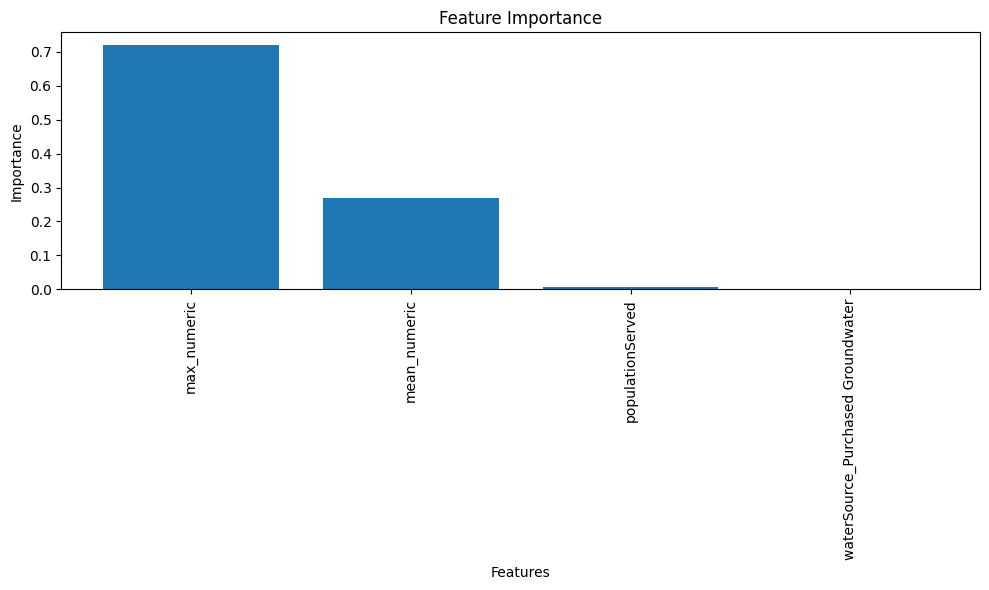

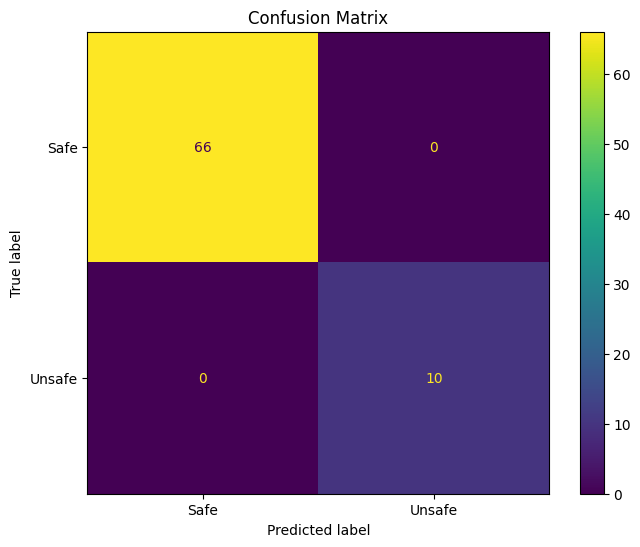

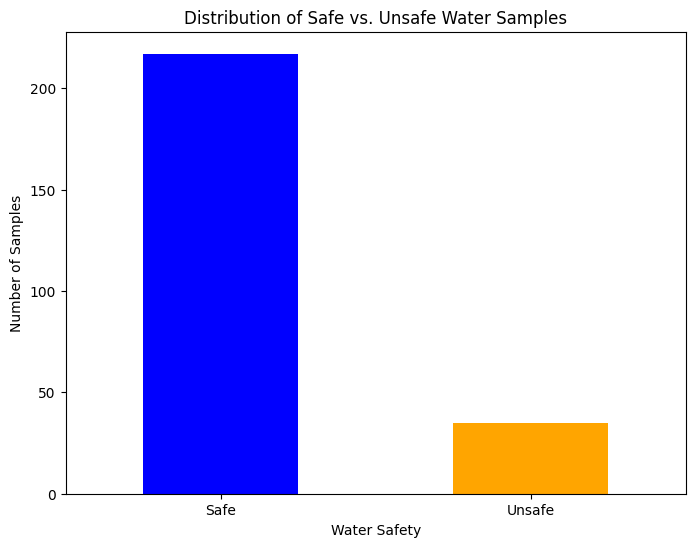

   mean_numeric  max_numeric  populationServed predicted_safety
0         0.500         0.50               639             Safe
1         1.100         1.10              1212             Safe
2         0.935         1.37                39             Safe
3         0.500         0.50               135             Safe
4         0.935         1.37               364             Safe


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/lyon.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Data Cleaning and Preprocessing
def preprocess_data(df):
    # Extract numerical values from 'mean' and 'max' columns
    df['mean_numeric'] = df['mean'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
    df['max_numeric'] = df['max'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    # Create a label for water safety
    # Assuming a threshold for Arsenic as 10 ug/L (you can adjust this)
    # Water is considered 'Unsafe' if mean or max exceeds 10 ug/L
    df['water_safety'] = np.where((df['mean_numeric'] > 10) | (df['max_numeric'] > 10), 'Unsafe', 'Safe')

    # Selecting relevant features
    df_cleaned = df[['waterSource', 'mean_numeric', 'max_numeric', 'populationServed', 'water_safety']]

    return df_cleaned

# Preprocess the data
cleaned_data = preprocess_data(data)

# Encode categorical variables
cleaned_data = pd.get_dummies(cleaned_data, columns=['waterSource'], drop_first=True)

# Split the data into features (X) and labels (y)
X = cleaned_data.drop('water_safety', axis=1)
y = cleaned_data['water_safety']

# Convert labels to binary form (Safe = 0, Unsafe = 1)
y = np.where(y == 'Safe', 0, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Unsafe']))

# Visualization

# 1. Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = rf_classifier.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Safe', 'Unsafe'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()

# 3. Distribution of 'Safe' vs. 'Unsafe' Water Samples
plt.figure(figsize=(8, 6))
cleaned_data['water_safety'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Safe vs. Unsafe Water Samples')
plt.xlabel('Water Safety')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

# Make predictions on the entire dataset (cleaned_data) to showcase the results
cleaned_data['predicted_safety'] = rf_classifier.predict(X)

# Map numerical predictions back to labels
cleaned_data['predicted_safety'] = np.where(cleaned_data['predicted_safety'] == 0, 'Safe', 'Unsafe')

# Create a final table showing water sources and their predicted safety
result_table = cleaned_data[['mean_numeric', 'max_numeric', 'populationServed', 'predicted_safety']]

# Display the result table
print(result_table.head())  # You can also save this to a CSV or other file format
